In [47]:
from src.scripts.hydrate_db import create_db_connection
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

SQL_PATH = os.path.join(os.path.abspath(""), "sql")

con = create_db_connection()

In [48]:
SQL_PATH

'C:\\Users\\tthompson2\\Documents\\REPOS\\FFPlayground\\src\\sql'

# MATCHUP LUCK
## Lucky Wins and Unlucky Losses

Extremely lucky win = You won while being the second-lowest scorer in the league. The only person with a lower score was your opponent.
Lucky win = You won while being the third-lowest scorer in the league.

Extremely unlucky loss = You lost while being the second-highest scorer in the league. The only person with a higher score was your opponent.
Unlucky loss = You lost while being the third-highest scorer in the league.

`LuckScore = (NumExtremelyLuckyWins * 2) + NumLuckyWins - (NumExtremelyUnluckyLosses * 2) - NumUnluckyLosses`


In [49]:
## UNLUCKY DFS ##
with open(os.path.join(SQL_PATH, "analytics", "num_extremely_unlucky_losses.sql"), "r") as f:
    query = f.read()
    
extremely_unlucky_losses_df = pd.read_sql(query, con=con)

with open(os.path.join(SQL_PATH, "analytics", "num_unlucky_losses.sql"), "r") as f:
    query = f.read()
    
unlucky_losses_df = pd.read_sql(query, con=con)


In [50]:
## LUCKY DFS ##
with open(os.path.join(SQL_PATH, "analytics", "num_extremely_lucky_wins.sql"), "r") as f:
    query = f.read()
    
extremely_lucky_wins_df = pd.read_sql(query, con=con)

with open(os.path.join(SQL_PATH, "analytics", "num_lucky_wins.sql"), "r") as f:
    query = f.read()
    
lucky_wins_df = pd.read_sql(query, con=con)


In [51]:
## MERGE, CALC, SORT ##
luck_df = lucky_wins_df.merge(right=extremely_lucky_wins_df, how="outer", on="RealName").merge(
    right=unlucky_losses_df, how="outer", on="RealName"
).merge(
    right=extremely_unlucky_losses_df, how="outer", on="RealName"
).fillna(0)
luck_df["LuckScore"] = luck_df["NumLuckyWins"] + luck_df["NumExtremelyLuckyWins"] * 2 - luck_df["NumUnluckyLosses"] - (luck_df["NumExtremelyUnluckyLosses"] * 2)
luck_df = luck_df.sort_values(by="LuckScore", ascending=False)

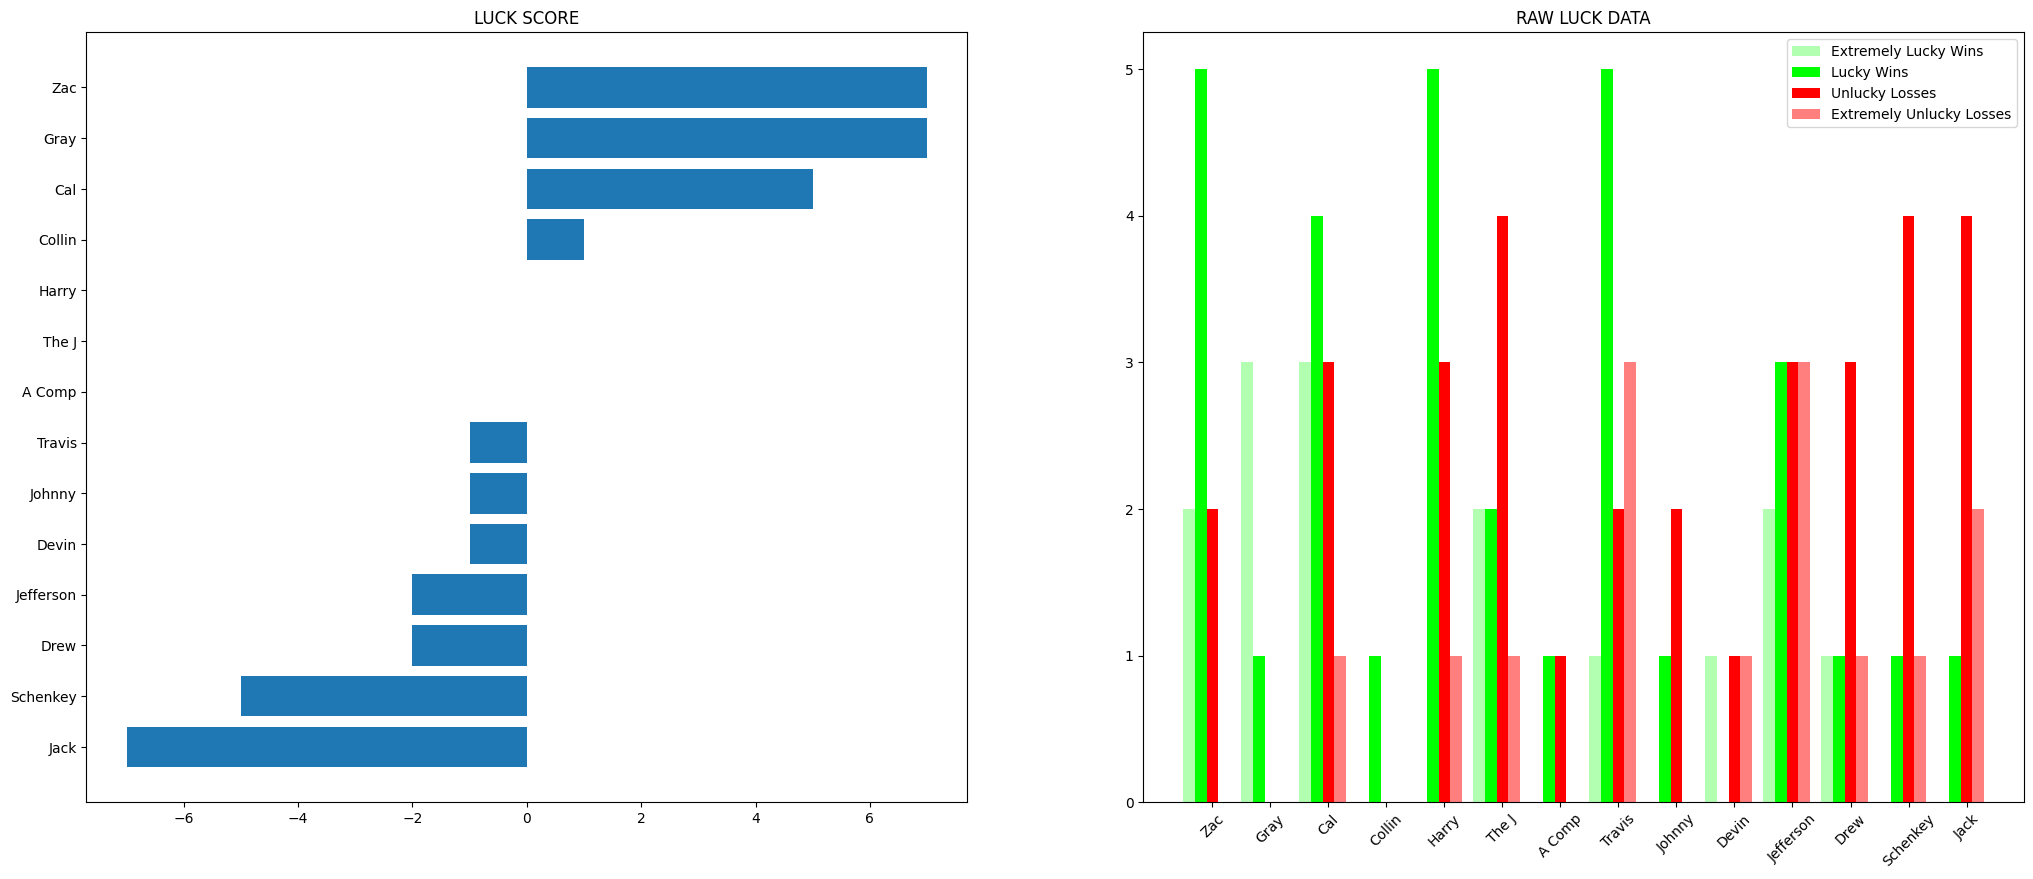

In [93]:
## PLOT ##

fig, (ax1, ax2) = plt.subplots(1, 2)
player_range = np.arange(len(luck_df))

## luck score ##
ax1.barh(player_range, luck_df["LuckScore"], align="center")
ax1.set_yticks(player_range, labels=luck_df["RealName"])
ax1.invert_yaxis()
ax1.set_title("MATCHUP LUCK SCORE")
# ax1.set_figwidth(19)

## raw data ##
labels = list(luck_df["RealName"])
width = 0.2
ax2.set_title("RAW LUCK DATA")
ax2.bar(player_range -  (width * 2), luck_df["NumExtremelyLuckyWins"], width, label="Extremely Lucky Wins", color=(0, 1, 0, 0.3))
ax2.bar(player_range - width, luck_df["NumLuckyWins"], width,  label="Lucky Wins", color=(0, 1, 0, 1))
ax2.bar(player_range, luck_df["NumUnluckyLosses"], width, label="Unlucky Losses", color=(1, 0, 0,  1))
ax2.bar(player_range + width, luck_df["NumExtremelyUnluckyLosses"], width, label="Extremely Unlucky Losses", color=(1, 0, 0,  0.5))

ax2.set_xticks(player_range, labels=luck_df["RealName"])
ax2.set_xticklabels(labels)
ax2.legend()
fig.set_figwidth(25)
fig.set_figheight(10)
plt.xticks(rotation=45)
plt.show()


Based on the formula I came up with, we can empirically determine that Jack has had the worst matchup luck of all of us over the history of our league, while Zac has had the best luck. Somehow that seems extremely fitting.

# CUMULATIVE PODIUM STATS
## Calculating an overall league score based on your cumulative podium finishes

`OverallScore = (3 * NumFirstPlaceFinishes) + (2 * NumSecondPlaceFinishes) + NumThirdPlaceFinishes`

In [94]:
## SELECT PODIUM BY YEAR ##
with open(os.path.join(SQL_PATH, "analytics", "select_podium_by_year.sql"), "r") as f:
    query = f.read()
    
podium = pd.read_sql(query, con=con)

In [120]:
# podium[(podium["RealName"] == "Travis") & (podium["FinalRank"] == 1)]
import emoji
all_player_names = pd.read_sql("SELECT DISTINCT RealName FROM leaguemembers", con=con)["RealName"].to_list()

cumulative_podium_df = pd.DataFrame(
    {
        "RealName": n,
        "FirstPlaceFinishes": [f'{emoji.emojize(":1st_place_medal:")} {y}' for y in list(podium[(podium["RealName"] == n) & (podium["FinalRank"] == 1)]["Year"])],
        "SecondPlaceFinishes": [f'{emoji.emojize(":2nd_place_medal:")} {y}' for y in list(podium[(podium["RealName"] == n) & (podium["FinalRank"] == 2)]["Year"])],
        "ThirdPlaceFinishes": [f'{emoji.emojize(":3rd_place_medal:")} {y}' for y in list(podium[(podium["RealName"] == n) & (podium["FinalRank"] == 3)]["Year"])]
    }
    for n in all_player_names
)
cumulative_podium_df["OverallScore"] = (
        3 * cumulative_podium_df["FirstPlaceFinishes"].str.len()
        + 2 * cumulative_podium_df["SecondPlaceFinishes"].str.len()
        + cumulative_podium_df["ThirdPlaceFinishes"].str.len()
)   

cumulative_podium_df = cumulative_podium_df.sort_values(by="OverallScore", ascending=False)
cumulative_podium_df

,RealName,FirstPlaceFinishes,SecondPlaceFinishes,ThirdPlaceFinishes,OverallScore
2,Harry,[],"[🥈 2015, 🥈 2017, 🥈 2019, 🥈 2020]",[🥉 2018],9
7,Jack,"[🥇 2020, 🥇 2022]",[],"[🥉 2016, 🥉 2019, 🥉 2023]",9
3,Jefferson,[🥇 2023],[🥈 2022],"[🥉 2017, 🥉 2021]",7
4,The J,[🥇 2017],[🥈 2023],[🥉 2020],6
6,Schenkey,[🥇 2015],[🥈 2016],[🥉 2022],6
13,Drew,[🥇 2018],[🥈 2021],[],5
0,Travis,[🥇 2019],[],[],3
8,Devin,[🥇 2016],[],[],3
15,Gray,[🥇 2021],[],[],3
14,Cal,[],[🥈 2018],[],2


Here we can see that poor Harry "early 90s Bills" Sharp has smelled victory 4(!) times but never tasted its sweet nectar. Also interesting to note that while Jack has had the worst historical matchup luck, he is still tied for first in overall league score. 